## 1. Topology-based Similarity Scores

#### Task (a)
Create a synthetic network with heterogeneous degrees for which Adamic-Adar index based link prediction has larger predictive power (in terms of AUC) than Szymkiewicz-Simpson coefficient based link prediction.

In [2]:
import random
import multiprocessing as mp
from functools import partial

import scipy as sp
import numpy as np
import pandas as pd
import pathpy as pp
import plotly.express as px
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [7]:
def generate_zipf_network(n, gamma):
    ds = [1]
    while not pp.generators.random_graphs.is_graphic_Erdos_Gallai(ds):
        ds = sp.stats.zipf.rvs(a=gamma, size=n)
    return pp.generators.random_graphs.Molloy_Reed(ds)

In [8]:
syntectic_network = generate_zipf_network(100, 2.3)
syntectic_network.plot(node_size=5, node_label='')

In [9]:
train, test = pp.algorithms.evaluation.train_test_split(syntectic_network, test_size = 0.25, split='edge')

In [10]:
def add_negative_samples(train, test):
    test_set = pd.DataFrame([ (e.v.uid, e.w.uid, 1) for e in test.edges ], columns=['v', 'w', 'link'])
    nodes = [v.uid for v in test.nodes]
    num = 0
    negative = []

    # add same number of negative instances as positive instances
    while num<test.number_of_edges():
        v, w = np.random.choice(nodes, 2, replace=False)

        # make sure that nodes are neither connected in training nor in test network
        if (v, w) not in test.edges and (v, w) not in train.edges:
            # add node pair with ground truth (link) zero
            negative.append((v, w, 0))
            num += 1
    negative = pd.DataFrame(negative, columns=['v', 'w', 'link'])

    # add to test set
    test_set = pd.concat([negative, test_set], ignore_index=True)
    test_set.reset_index()
    return test_set

In [11]:
test_set = add_negative_samples(train, test)
test_set

,v,w,link
0,85,14,0
1,75,26,0
2,62,94,0
3,66,46,0
4,51,6,0
5,82,3,0
6,92,31,0
7,81,40,0
8,94,32,0
9,28,60,0


In [12]:
def assign_sim(network, test_df, similarity_score, **kwargs):
    sim = []
    for index, row in test_df.iterrows():
        sim.append(similarity_score(network, row['v'], row['w'], **kwargs))
    test_df['sim'] = sim


def compute_ROC(test_set):
    fpr, tpr, thresholds = roc_curve(test_set['link'].values, test_set['sim'].values)
    plt.plot(fpr, tpr)
    plt.plot(np.linspace(0,1), np.linspace(0,1), ls='--', c='r', alpha=0.5)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print('AUC =', auc(fpr, tpr))

Szymcowich-Simpson score

In [13]:
def overlap_coefficient(n, v, w):
    N_v = n.successors[v]
    N_w = n.successors[w]
    if len(N_v) == 0 or len(N_w) == 0:
        return 0
    else:
        return len(N_v.intersection(N_w))/min(len(N_v), len(N_w))

Adamic-Adar index

In [14]:
def adamic_adar_index(n, v, w):
    A = 0
    N_v = n.successors[v]
    N_w = n.successors[w]
    for u in N_v.intersection(N_w):
        A += 1 / np.log(len(n.successors[u.uid]))
    return A

AUC = 0.475


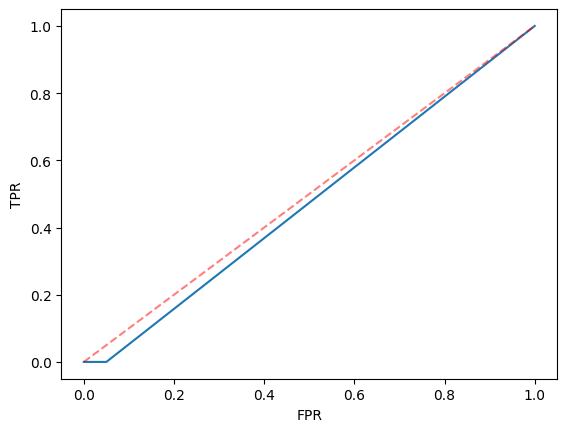

In [15]:
assign_sim(train, test_set, overlap_coefficient)
compute_ROC(test_set)

AUC = 0.475


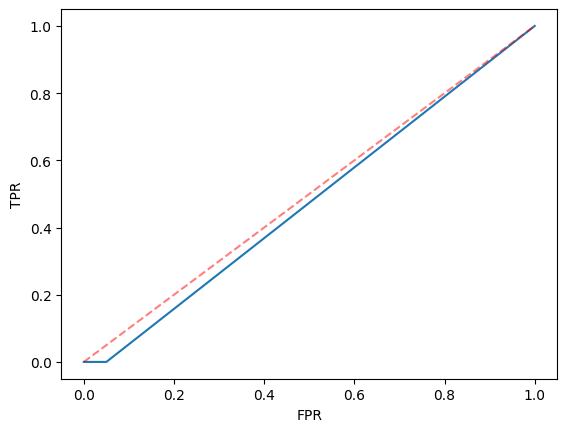

In [16]:
assign_sim(train, test_set, adamic_adar_index)
compute_ROC(test_set)

As we can judge for this network Adamic-Adar will have larger AUC ROC score than Szymkiewicz-Simpson coefficient.

#### Task (b)
Consider the cosine similarity score between two nodes v and w in an undirected network with no self-loops or multi-edges. Prove that it corresponds to the number of common neighbors normalized by the geometric mean of the degrees $d_v$ and $d_w$.

Lets first consider the formula of cosine similarity:

$$cossim(i, j) = \frac{\vec{A_i} \times \vec{A_j}}{|\vec{A_i}| |\vec{A_j}|}$$

The numernator part is a vectors dot $\vec{A_i} \times \vec{A_j}^T$ which means number of walks of length 2 between nodes i and j. So it is also the number of common neighbours between them because each node relates only to one node. The norm of the vector is the $\frac{1}{2}$ power from their sum of squares $\sqrt{\sum_{j = 0}^n A_{ij} ^ 2}$ but at the same time the $A_{ij}$ can be 0 or 1 so the norm of the vector in a such case is $\sqrt d_i$. So the formula of the cosine similarity is:

$$cossim(i, j) = \frac{C(i, j)}{\sqrt{d_i d_j}}$$

That is what we need to prove.

#### Task (c)
Consider a random network with heterogeneous node degrees. Compute the Katz index and the Leicht-Holme-Newman index for all node pairs and plot the correlation between node similarities and the product of the node degrees for all node pairs. What do you observe?

Let`s use network from task 1.a.

In [17]:
def katz_index_matrix(network: pp.Network, **kwargs):
    A = pp.algorithms.adjacency_matrix(network)
    I = sp.sparse.identity(network.number_of_nodes())
    S = sp.sparse.linalg.inv(I - kwargs['beta'] * A) - I
    return S

In [18]:
def LHN_index_matrix(network: pp.Network, **kwargs) -> float:
    A = pp.algorithms.adjacency_matrix(network)
    ev = sp.sparse.linalg.eigs(A, which="LM", k=2, return_eigenvectors=False)
    m = network.number_of_edges()
    eigenvalues_sorted = np.sort(np.absolute(ev))
    lambda_1 = eigenvalues_sorted[0]
    D = sp.sparse.diags(pp.statistics.degree_sequence(network))
    I = sp.sparse.identity(network.number_of_nodes())
    S = 2*m*lambda_1*sp.sparse.linalg.inv(D) * sp.sparse.linalg.inv(I - kwargs['alpha']*A/lambda_1)*sp.sparse.linalg.inv(D)
    return S

In [19]:
degrees_sequence = syntectic_network.degree_sequence()

In [20]:
degrees_multiplication = np.array([
    d_v * d_w
    for d_v in degrees_sequence 
    for d_w in degrees_sequence
])

degrees_multiplication.shape

(10000,)

In [21]:
katz_values = katz_index_matrix(syntectic_network, beta=0.3).todense().A1
katz_values.shape

/home/user/PycharmProjects/ML_for_Complex_Networks/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/user/PycharmProjects/ML_for_Complex_Networks/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


(10000,)

In [22]:
lhn_values = LHN_index_matrix(syntectic_network, alpha=0.3).todense().A1
lhn_values.shape

/home/user/PycharmProjects/ML_for_Complex_Networks/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


(10000,)

In [23]:
katz_corr_matrix = np.corrcoef(degrees_multiplication, katz_values)
katz_corr_matrix

array([[1.        , 0.44428008],
       [0.44428008, 1.        ]])

In [24]:
lhn_corr_matrix = np.corrcoef(degrees_multiplication, lhn_values)
lhn_corr_matrix

array([[ 1.        , -0.03446553],
       [-0.03446553,  1.        ]])

In [25]:
px.scatter(x=degrees_multiplication, y=katz_values, opacity=0.5, title='Katz index')

In [26]:
px.scatter(x=degrees_multiplication, y=lhn_values, opacity=0.5, title='LHN index')

There is more correlation in Katz index. The LHN index is corrected fior degrees.

#### Task (d)
Consider the probabilistic generative model to generate Watts-Strogatz networks with different parameters of the rewiring probability p. This model is implemented in pathpy and described in the script Statistical Network Analysis. Generate networks for different rewiring probabilities and test the AUC of different similarity scores for link prediction. How does the parameter p influence the performance of different scores?

Let`s first define tools for calculating ROC AUC scores

In [27]:
p_space = np.linspace(0, 1, 50)

In [37]:
def find_roc_auc(network: pp.Network, similarity_score):
    train, test = pp.algorithms.evaluation.train_test_split(network, test_size = 0.25, split='edge')
    test_set = add_negative_samples(train, test)
    assign_sim(train, test_set, similarity_score)
    return roc_auc_score(test_set['link'].values, test_set['sim'].values)

In [38]:
def main_operation(p_value, simiraty_score, samples=2):
    results = np.array([
        find_roc_auc(
            pp.generators.Watts_Strogatz(20, 3, p_value),
            simiraty_score
        )
        for _ in range(samples)
    ])
    return np.mean(results)

In [39]:
def get_roc_auc_scores(p_space, similarity_score, samples=2):
    calculate_metric = partial(main_operation, simiraty_score=similarity_score, samples=samples)
    with mp.Pool(mp.cpu_count()) as pool:
        results = [i for i in tqdm(pool.imap_unordered(calculate_metric, p_space), total=len(p_space))]
    
    return results

Now let`s for similarity scores one by one.
The first will be cosine similarity.

In [40]:
def cosine_similarity(network, v, w):    
    if network.degrees()[v] == 0 or network.degrees()[w] == 0:
        return 0
    else:
        A = pp.algorithms.adjacency_matrix(network)
        v_v = A[network.nodes.index[v]].todense().A1
        v_w = A[network.nodes.index[w]].todense().A1
        return np.dot(v_v, v_w)/(np.linalg.norm(v_v)*np.linalg.norm(v_w))

In [44]:
results = get_roc_auc_scores(p_space, cosine_similarity, samples=10)

  0%|          | 0/50 [00:00<?, ?it/s]

In [45]:
px.scatter(x=p_space, y=results, opacity=0.5, title='Cosine similarity dependency on p')

The ROC score goes down with increasing P.

Let`s try Adamic-Adar index.

In [46]:
results = get_roc_auc_scores(p_space, adamic_adar_index, samples=10)

  0%|          | 0/50 [00:00<?, ?it/s]

In [47]:
px.scatter(x=p_space, y=results, opacity=0.5, title='Adamic-Adar index dependency on p')

One more time with increasing p the ROC AUC score goes down.

Let`s try Katz index.

In [52]:
def katz_index(network, v, w, **kwargs) -> float:
    A = pp.algorithms.adjacency_matrix(network)
    I = sp.sparse.identity(network.number_of_nodes())
    S = sp.sparse.linalg.inv((I - kwargs['beta'] * A).tocsc()) - I
    return S[network.nodes.index[v], network.nodes.index[w]]

In [53]:
katz_index_to_apply = partial(katz_index, beta=0.3)
results = get_roc_auc_scores(p_space, katz_index_to_apply, samples=10)

  0%|          | 0/50 [00:00<?, ?it/s]

In [54]:
px.scatter(x=p_space, y=results, opacity=0.5, title='Katz index dependency on p')

For the Katz index the ROC SUC score grows.

In [82]:
def LHN_index(network, v, w, **kwargs) -> float:
    A = pp.algorithms.adjacency_matrix(network)
    D = sp.sparse.diags(pp.statistics.degree_sequence(network)).tocsc()
    
    if np.allclose(np.linalg.det(D.todense()), 0):
        largest_connected_component = pp.algorithms.largest_connected_component(network)
        if v in largest_connected_component.nodes and w in largest_connected_component.nodes:
            return LHN_index(largest_connected_component, v, w, **kwargs)
        else:
            return 0.
    
    ev = sp.sparse.linalg.eigs(A, which="LM", k=2, return_eigenvectors=False)
    m = network.number_of_edges()
    lambda_1 = max(np.absolute(ev))
    inverted_d = sp.sparse.linalg.inv(D)
    I = sp.sparse.identity(network.number_of_nodes())
    S = 2 * m * lambda_1 * inverted_d * sp.sparse.linalg.inv((I - kwargs['alpha'] * A / lambda_1).tocsc()) * inverted_d
    return S[network.nodes.index[v], network.nodes.index[w]]


In [83]:
lhn_index_to_apply = partial(LHN_index, alpha=0.3)
results = get_roc_auc_scores(p_space, lhn_index_to_apply, samples=10)

  0%|          | 0/50 [00:00<?, ?it/s]

In [84]:
px.scatter(x=p_space, y=results, opacity=0.5, title='LHN dependency on p')

ROC AUC values also go down with increasing p.

In [3]:
network = pp.generators.Watts_Strogatz(30, 4, 0.5)
A = pp.algorithms.adjacency_matrix(network)
ev = sp.sparse.linalg.eigs(A, which="LM", k=2, return_eigenvectors=False)
eigenvalues_sorted = np.sort(np.absolute(ev))
print(eigenvalues_sorted)
lambda_1 = eigenvalues_sorted[0]
print(lambda_1)

[4.19477772 8.41096272]
4.1947777247881035
